In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # disable warnings and info
import tensorflow as tf
import imageio
import moviepy.editor as mpy
from tqdm import trange
import glob

In [2]:
SAMPLE_COL = 8
SAMPLE_ROW = 8
SAMPLE_NUM = SAMPLE_COL * SAMPLE_ROW

IMG_H = 64
IMG_W = 64
IMG_C = 3
IMG_SHAPE = (IMG_H, IMG_W, IMG_C)

BATCH_SIZE = 1000
Z_DIM = 128
BZ = (BATCH_SIZE, Z_DIM)
BUF = 65536

alpha = 1.0e-04
beta1 = 0
beta2 = 0.9
LAMBDA = 10
W_EPOCH = 256

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
logical_gpus = tf.config.experimental.list_logical_devices('GPU')

In [4]:
def utPuzzle(imgs, row, col, path=None):
    h, w, c = imgs[0].shape
    out = np.zeros((h * row, w * col, c), np.uint8)
    for n, img in enumerate(imgs):
        j, i = divmod(n, col)
        out[j * h: (j + 1) * h, i * w: (i + 1) * w, :] = img
    if path is not None: imageio.imwrite(path, out)
    return out


def utMakeGif(imgs, fname, duration):
    n = float(len(imgs)) / duration
    clip = mpy.VideoClip(lambda t: imgs[int(n * t)], duration=duration)
    clip.write_gif(fname, fps=n)
    
def map_fun(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=IMG_C)
    img = tf.image.resize(img, [IMG_H, IMG_W])
    img = tf.cast(img, tf.float32)
    img = img / 255.
    return img

In [5]:
img_names = sorted(glob.glob('./data/img_align_celeba_png/*.png'))
dsTrain = tf.data.Dataset.from_tensor_slices(img_names)\
                               .map(map_fun, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
                               .shuffle(BUF)\
                               .batch(BATCH_SIZE, drop_remainder=True)\
                               .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
print(len(img_names))

202599


In [6]:
import tensorflow.keras as keras


def GAN(img_shape, z_dim):
    # x-shape
    xh, xw, xc = img_shape
    # z-shape
    zh = xh // 4
    zw = xw // 4

    # return Generator and Discriminator
    return keras.Sequential([  # Generator
        keras.layers.Dense(units=1024, input_shape=(z_dim,)),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Dense(units=zh*zw*256),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Reshape(target_shape=(zh, zw, 256)),
        keras.layers.Conv2DTranspose(
            filters=32,
            kernel_size=5,
            strides=2,
            padding='SAME'
        ),
        keras.layers.BatchNormalization(),
        keras.layers.ReLU(),
        keras.layers.Conv2DTranspose(
            filters=xc,
            kernel_size=5,
            strides=2,
            padding='SAME',
            activation=keras.activations.sigmoid
        ),
    ]), keras.Sequential([  # Discriminator
        keras.layers.Conv2D(
            filters=32,
            kernel_size=5,
            strides=(2, 2),
            padding='SAME',
            input_shape=img_shape,
        ),
        keras.layers.LeakyReLU(),
        keras.layers.Conv2D(
            filters=128,
            kernel_size=5,
            strides=(2, 2),
            padding='SAME'
        ),
        # keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Flatten(),
        keras.layers.Dense(units=1024),
        # keras.layers.BatchNormalization(),
        keras.layers.LeakyReLU(),
        keras.layers.Dense(units=1),
    ])
s = tf.random.normal([SAMPLE_NUM, Z_DIM])

In [7]:
WG, WD = GAN(IMG_SHAPE, Z_DIM)
optimizer_g = keras.optimizers.Adam(alpha, beta1, beta2)
optimizer_d = keras.optimizers.Adam(alpha, beta1, beta2)


@tf.function
def Imp_WGTrain(c1):
    z = tf.random.normal(BZ)

    with tf.GradientTape() as tpd:
        c0 = WG(z, training=True)

        z1 = WD(c1, training=True)
        z0 = WD(c0, training=True)

        lg = tf.reduce_mean(-z0)

        eps = tf.random.uniform([BATCH_SIZE, 1, 1, 1])
        x_hat = eps * c1 + (1 - eps) * c0
        grad = tf.gradients(WD(x_hat, training=True), x_hat)[0]
        regulation_term = (tf.sqrt(tf.reduce_sum(grad ** 2, axis=[1, 2, 3])) - 1.) ** 2

        ld = tf.reduce_mean(z0 - z1 + LAMBDA * regulation_term)

    gradient_g = tpd.gradient(lg, WG.trainable_variables)
    
    optimizer_g.apply_gradients(zip(gradient_g, WG.trainable_variables))

    return lg, ld


@tf.function
def Imp_WDTrain(c1):
    z = tf.random.normal(BZ)

    with tf.GradientTape() as tpd:
        c0 = WG(z, training=True)

        z1 = WD(c1, training=True)
        z0 = WD(c0, training=True)

        lg = tf.reduce_mean(-z0)

        eps = tf.random.uniform([BATCH_SIZE, 1, 1, 1])
        x_hat = eps * c1 + (1 - eps) * c0
        grad = tf.gradients(WD(x_hat, training=True), x_hat)[0]
        regulation_term = (tf.sqrt(tf.reduce_sum(grad ** 2, axis=[1, 2, 3])) - 1.) ** 2

        ld = tf.reduce_mean(z0 - z1 + LAMBDA * regulation_term)

    gradient_d = tpd.gradient(ld, WD.trainable_variables)
    optimizer_d.apply_gradients(zip(gradient_d, WD.trainable_variables))

    return lg, ld

In [8]:
Imp_WTrain = (
    Imp_WDTrain,
    Imp_WDTrain,
    Imp_WDTrain,
    Imp_WDTrain,
    Imp_WDTrain,
    Imp_WGTrain
)

WCritic = len(Imp_WTrain)

Epoch 0
Epoch 10
Epoch 20
Epoch 30


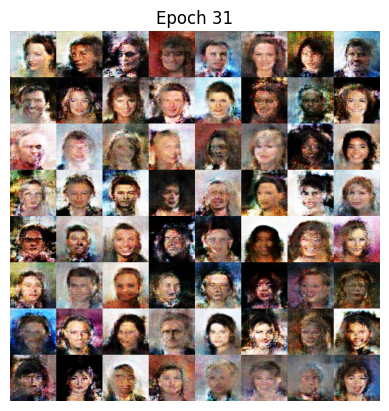

Epoch 40
Epoch 50
Epoch 60


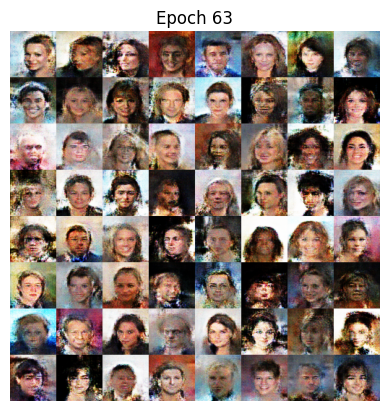

Epoch 70
Epoch 80
Epoch 90


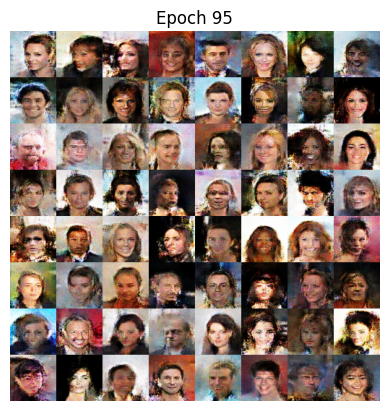

Epoch 100
Epoch 110
Epoch 120


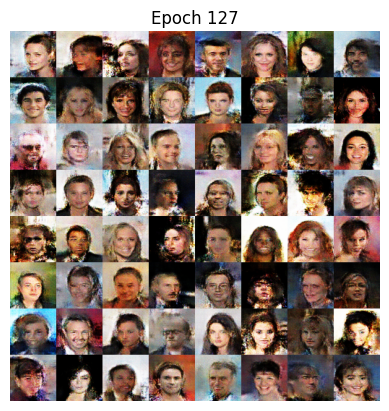

Epoch 130
Epoch 140
Epoch 150


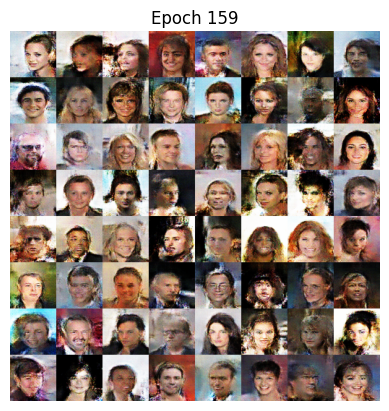

Epoch 160
Epoch 170
Epoch 180
Epoch 190


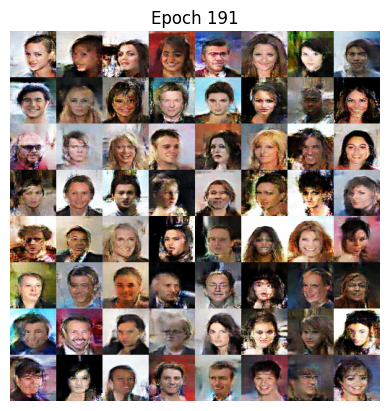

Epoch 200
Epoch 210
Epoch 220


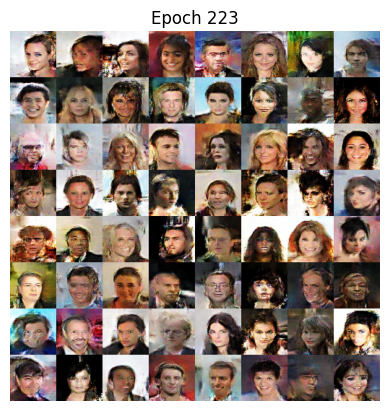

Epoch 230
Epoch 240
Epoch 250


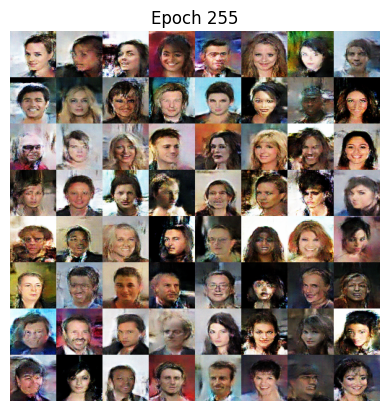

In [9]:
wlg = [None] * W_EPOCH  # record loss of g for each epoch
wld = [None] * W_EPOCH  # record loss of d for each epoch
wsp = [None] * W_EPOCH  # record sample images for each epoch

ctr = 0

for epoch in range(W_EPOCH):
    if(epoch % 10 == 0):
        print("Epoch %d" % epoch)
    lgt = 0.0
    ldt = 0.0
    for c1 in dsTrain:
        lg, ld = Imp_WTrain[ctr](c1)
        ctr = ctr + 1 if ctr + 1 < WCritic else 0
        lgt += lg.numpy()
        ldt += ld.numpy()

    wlg[epoch] = lgt / len(img_names)
    wld[epoch] = ldt / len(img_names)

    out = WG(s, training=False)
    img = utPuzzle(
        (out * 255.0).numpy().astype(np.uint8),
        SAMPLE_COL,
        SAMPLE_ROW,
        "imgs/Improved_WGAN_%04d.png" % epoch
    )
    wsp[epoch] = img
    if (epoch + 1) % 32 == 0:
        plt.imshow(img)
        plt.axis('off')
        plt.title("Epoch %d" % epoch)
        plt.show()

In [10]:
utMakeGif(np.array(wsp), './imgs/Improved_WGAN.gif', duration=2)

MoviePy - Building file ./imgs/Improved_WGAN.gif with imageio.


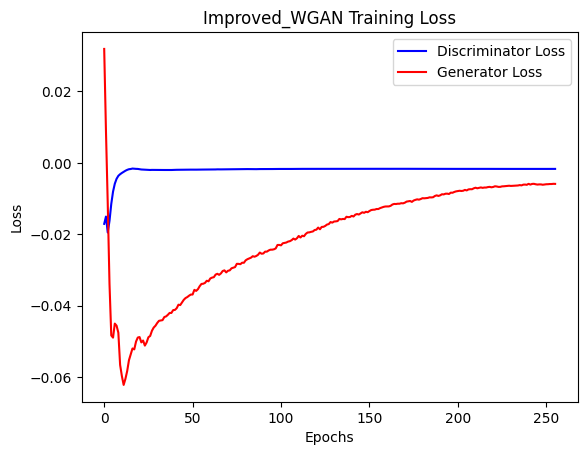

<Figure size 640x480 with 0 Axes>

In [15]:
plt.plot(range(W_EPOCH), wld, color='blue', label='Discriminator Loss')
plt.plot(range(W_EPOCH), wlg, color='red', label='Generator Loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Improved_WGAN Training Loss')
plt.show()
plt.savefig('./imgs/Improved_WGAN_Training_Loss.png')

## Report  
這次的作業是將Wasserstein GAN(WGAN)改成Improved WGAN，其中的改動為像是把原本Train function中的optimizer從RMSProp改成Adam和實作WGAN with penlty，  
訓練時是用64x64的照片大小並取output出8x8的結果。雖然還是有幾張照片有點模糊但比起WGAN算是好了不少。